In [170]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.pipeline import Pipeline



In [171]:
shelter_data = pd.read_csv('./data/train.csv')
shelter_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


**EDA and Data Cleaning**

In [172]:
outcome_dict = {'Adoption': 0,
               'Transfer': 1,
               'Return_to_owner': 2,
               'Euthanasia': 3,
               'Died':4}

In [173]:
shelter_data['OutcomeTypeNum'] = shelter_data["OutcomeType"]


In [174]:
shelter_data.replace({"OutcomeTypeNum": outcome_dict}, inplace = True)

In [175]:
shelter_data.describe()

,OutcomeTypeNum
count,26729.000000
mean,0.914625
std,0.934738
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,4.000000


In [176]:
shelter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   AnimalID        26729 non-null  object
 1   Name            19038 non-null  object
 2   DateTime        26729 non-null  object
 3   OutcomeType     26729 non-null  object
 4   OutcomeSubtype  13117 non-null  object
 5   AnimalType      26729 non-null  object
 6   SexuponOutcome  26728 non-null  object
 7   AgeuponOutcome  26711 non-null  object
 8   Breed           26729 non-null  object
 9   Color           26729 non-null  object
 10  OutcomeTypeNum  26729 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 2.2+ MB


In [177]:
shelter_data['DateTime'] = pd.to_datetime(shelter_data['DateTime'])

In [178]:
shelter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   AnimalID        26729 non-null  object        
 1   Name            19038 non-null  object        
 2   DateTime        26729 non-null  datetime64[ns]
 3   OutcomeType     26729 non-null  object        
 4   OutcomeSubtype  13117 non-null  object        
 5   AnimalType      26729 non-null  object        
 6   SexuponOutcome  26728 non-null  object        
 7   AgeuponOutcome  26711 non-null  object        
 8   Breed           26729 non-null  object        
 9   Color           26729 non-null  object        
 10  OutcomeTypeNum  26729 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 2.2+ MB


In [179]:
shelter_data.shape

(26729, 11)

In [180]:
shelter_data.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
OutcomeTypeNum        0
dtype: int64

In [181]:
shelter_data = shelter_data[shelter_data['AgeuponOutcome'].notna()]

In [182]:
shelter_data.isnull().sum()

AnimalID              0
Name               7673
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome        0
Breed                 0
Color                 0
OutcomeTypeNum        0
dtype: int64

We aren't overly concerned about the null values in Name because without doing some for of NLP, which is beyond the scope of the project in this timeframe, the information on Name won't be used to predict outcome and there is no way to reasonably impute the null name values. 

In [183]:
null_subtype = shelter_data[shelter_data['OutcomeSubtype'].isna()]

In [184]:
null_subtype['OutcomeType'].value_counts()

Adoption           8803
Return_to_owner    4786
Died                 16
Transfer              6
Euthanasia            1
Name: OutcomeType, dtype: int64

We wanted to see if the null values in the subtype column were associated with certain types of outcomes

In [185]:
pd.set_option("display.max_rows", None)
shelter_data['OutcomeSubtype'].value_counts()

Partner                7816
Foster                 1800
SCRP                   1583
Suffering              1000
Aggressive              320
Offsite                 165
In Kennel               114
Behavior                 86
Rabies Risk              74
Medical                  66
In Foster                52
Enroute                   8
Court/Investigation       6
At Vet                    4
In Surgery                3
Barn                      2
Name: OutcomeSubtype, dtype: int64

In [186]:
shelter_data['SexuponOutcome'].value_counts()

Neutered Male    9779
Spayed Female    8819
Intact Male      3519
Intact Female    3504
Unknown          1089
Name: SexuponOutcome, dtype: int64

In [187]:
pd.set_option("display.max_rows", None)
shelter_data['AgeuponOutcome'].value_counts()

1 year       3969
2 years      3742
2 months     3397
3 years      1823
1 month      1281
3 months     1277
4 years      1071
5 years       992
4 months      888
6 years       670
3 weeks       659
5 months      652
6 months      588
8 years       536
7 years       531
2 weeks       529
10 months     457
10 years      446
8 months      402
4 weeks       334
9 years       288
7 months      288
12 years      234
9 months      224
1 weeks       171
11 months     166
1 week        146
13 years      143
11 years      126
3 days        109
2 days         99
14 years       97
15 years       85
1 day          66
6 days         50
4 days         50
16 years       36
5 days         24
0 years        22
17 years       17
5 weeks        11
18 years       10
19 years        3
20 years        2
Name: AgeuponOutcome, dtype: int64

We want to change this column to a continuous variable of age as an integer 

In [188]:
age_dict = {'1 year': 1, 
    '2 years' : 2,      
    '2 months' : 0.17,    
    '3 years': 3,     
    '1 month' : 0.8,      
    '3 months' : 0.25,     
    '4 years':  4,   
    '5 years': 5,      
    '4 months': 0.33,     
    '6 years': 6,      
    '3 weeks': 0.06,      
    '5 months': 0.42,
    '6 months': 0.5,      
    '8 years': 8,      
    '7 years': 7,      
    '2 weeks': 0.04,      
    '10 months': 0.83,   
    '10 years': 10,    
    '8 months': 0.67,     
    '4 weeks': 0.08,     
    '9 years': 9,      
    '7 months': 0.58,     
    '12 years': 12,     
    '9 months': 0.75,     
    '1 weeks': 0.02,      
    '11 months': 0.92,   
    '1 week':  0.02,     
    '13 years': 13,    
    '11 years': 11,    
    '3 days': 0.01,       
    '2 days': 0.01,        
    '14 years': 14,     
    '15 years': 15,      
    '1 day': 0,        
    '6 days': 0.02,       
    '4 days': 0.01,       
    '16 years': 16,      
    '5 days': 0.01,        
    '0 years': 0,        
    '17 years': 17,      
    '5 weeks': 0.10,      
    '18 years': 18,     
    '19 years': 19,      
    '20 years': 20}        

In [189]:
shelter_data['AgeInYears'] = shelter_data['AgeuponOutcome']

In [190]:
shelter_data.replace({"AgeInYears": age_dict}, inplace = True)

In [191]:
shelter_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,OutcomeTypeNum,AgeInYears
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,2,1.00
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,3,1.00
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,0,2.00
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,1,0.06
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,1,2.00


In [192]:
shelter_data['OutcomeType'].value_counts()

Adoption           10769
Transfer            9406
Return_to_owner     4786
Euthanasia          1553
Died                 197
Name: OutcomeType, dtype: int64

In [193]:
shelter_data['OutcomeSubtype'].value_counts()

Partner                7816
Foster                 1800
SCRP                   1583
Suffering              1000
Aggressive              320
Offsite                 165
In Kennel               114
Behavior                 86
Rabies Risk              74
Medical                  66
In Foster                52
Enroute                   8
Court/Investigation       6
At Vet                    4
In Surgery                3
Barn                      2
Name: OutcomeSubtype, dtype: int64

In [194]:
pd.set_option("display.max_rows", 10)
shelter_data['Breed'].value_counts()

Domestic Shorthair Mix                 8794
Pit Bull Mix                           1906
Chihuahua Shorthair Mix                1766
Labrador Retriever Mix                 1363
Domestic Medium Hair Mix                839
                                       ... 
Shih Tzu/Dachshund                        1
Whippet/Shetland Sheepdog                 1
Patterdale Terr/Chihuahua Shorthair       1
Golden Retriever/Akita                    1
Boxer/German Shepherd                     1
Name: Breed, Length: 1380, dtype: int64

There are far too many breeds to create dummy variables. We are going to capture some of the influence of breed by making a column for pedigree, where animals that are mixes get a 0 and animals that are purebred or not a mix get a 1

In [195]:
shelter_data['Pedigree'] = shelter_data['Breed'].apply(lambda x: 0 if 'Mix' in x else 1)
 

In [196]:
shelter_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,OutcomeTypeNum,AgeInYears,Pedigree
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,2,1.00,0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,3,1.00,0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,0,2.00,0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,1,0.06,0
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,1,2.00,1


In [197]:
pd.set_option('display.max_rows', 10)
shelter_data['Color'].value_counts()

Black/White             2824
Black                   2288
Brown Tabby             1631
Brown Tabby/White        939
White                    930
                        ... 
Red Tick/Brown Merle       1
Yellow Brindle/Tan         1
Brown/Black Tabby          1
Black/Black Tabby          1
Sable/Buff                 1
Name: Color, Length: 366, dtype: int64

There are far too many color types to create dummy variables for so we decided to capture some of the influence of color by creating a column to indicate whethere the animal was a solid color (1) or a mix of colors(0).

In [198]:
shelter_data['Solid_Color'] = shelter_data['Color'].apply(lambda x: 0 if '/' in x else 1)

In [199]:
shelter_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,OutcomeTypeNum,AgeInYears,Pedigree,Solid_Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,2,1.00,0,0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,3,1.00,0,1
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,0,2.00,0,0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,1,0.06,0,1
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,1,2.00,1,1


In [200]:
shelter_data['DayofWeek'] = shelter_data['DateTime'].dt.dayofweek
shelter_data['Month'] = shelter_data['DateTime'].dt.month

In [201]:
shelter_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,OutcomeTypeNum,AgeInYears,Pedigree,Solid_Color,DayofWeek,Month
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,2,1.00,0,0,2,2
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,3,1.00,0,1,6,10
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,0,2.00,0,0,5,1
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,1,0.06,0,1,4,7
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,1,2.00,1,1,4,11


We wanted to pull out data on the days of the week and the months when dogs had different outcomes, because there might be relationships between these measures of time and the type of outcome. For DayofWeek, Monday is 0 and Sunday is 6. For Month January is 1 and December is 12

In [202]:
shelter_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26711 entries, 0 to 26728
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   AnimalID        26711 non-null  object        
 1   Name            19038 non-null  object        
 2   DateTime        26711 non-null  datetime64[ns]
 3   OutcomeType     26711 non-null  object        
 4   OutcomeSubtype  13099 non-null  object        
 5   AnimalType      26711 non-null  object        
 6   SexuponOutcome  26710 non-null  object        
 7   AgeuponOutcome  26711 non-null  object        
 8   Breed           26711 non-null  object        
 9   Color           26711 non-null  object        
 10  OutcomeTypeNum  26711 non-null  int64         
 11  AgeInYears      26711 non-null  float64       
 12  Pedigree        26711 non-null  int64         
 13  Solid_Color     26711 non-null  int64         
 14  DayofWeek       26711 non-null  int64         
 15  Mo

In [203]:
shelter_data['AgeInYears'].value_counts()

1.00     3969
2.00     3742
0.17     3397
3.00     1823
0.80     1281
         ... 
17.00      17
0.10       11
18.00      10
19.00       3
20.00       2
Name: AgeInYears, Length: 38, dtype: int64

In [204]:
shelter_data['AgeInYears'] = shelter_data['AgeInYears'].astype('int')

Creating dummy variables 

In [205]:
shelter_data.columns

Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color',
       'OutcomeTypeNum', 'AgeInYears', 'Pedigree', 'Solid_Color', 'DayofWeek',
       'Month'],
      dtype='object')

In [206]:
X = shelter_data[['AnimalType', 'SexuponOutcome', 'AgeInYears', 'Pedigree', 'Solid_Color', 'DayofWeek', 'Month']]
y = shelter_data['OutcomeTypeNum'] 

In [207]:
X.head()

,AnimalType,SexuponOutcome,AgeInYears,Pedigree,Solid_Color,DayofWeek,Month
0,Dog,Neutered Male,1,0,0,2,2
1,Cat,Spayed Female,1,0,1,6,10
2,Dog,Neutered Male,2,0,0,5,1
3,Cat,Intact Male,0,0,1,4,7
4,Dog,Neutered Male,2,1,1,4,11


In [208]:
X_dummies = pd.get_dummies(X, columns=['AnimalType', 'SexuponOutcome', 'DayofWeek', 'Month'], drop_first=True)
X_dummies.head()

,AgeInYears,Pedigree,Solid_Color,AnimalType_Dog,SexuponOutcome_Intact Male,SexuponOutcome_Neutered Male,SexuponOutcome_Spayed Female,SexuponOutcome_Unknown,DayofWeek_1,DayofWeek_2,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,1,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2,1,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [209]:
X_dummies.columns

Index(['AgeInYears', 'Pedigree', 'Solid_Color', 'AnimalType_Dog',
       'SexuponOutcome_Intact Male', 'SexuponOutcome_Neutered Male',
       'SexuponOutcome_Spayed Female', 'SexuponOutcome_Unknown', 'DayofWeek_1',
       'DayofWeek_2', 'DayofWeek_3', 'DayofWeek_4', 'DayofWeek_5',
       'DayofWeek_6', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12'],
      dtype='object')

The baseline AnimalType is Cats, the baseline SexuponOutcome is Intact Female, the baseline DayofWeek is 0 (Monday), the baseline Month is 1  

Visualizations

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


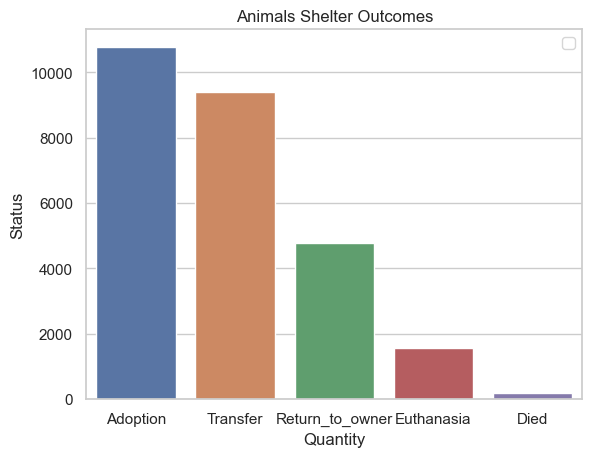

In [210]:
# BarPlot
df_outcome =  pd.DataFrame(shelter_data["OutcomeType"].value_counts())

sns.set_style('whitegrid')

x_ = (df_outcome.index)
y_ = df_outcome["OutcomeType"] 

ax = sns.barplot(x_, y_)
ax.set(xlabel='Quantity', ylabel='Status')
ax.set(title='Animals Shelter Outcomes')
ax.legend()
plt.show();

In [211]:
df_outcome.columns

Index(['OutcomeType'], dtype='object')

In [212]:
shelter_data.columns

Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color',
       'OutcomeTypeNum', 'AgeInYears', 'Pedigree', 'Solid_Color', 'DayofWeek',
       'Month'],
      dtype='object')

Text(0.5, 1.0, 'Distribution of Age Animals')

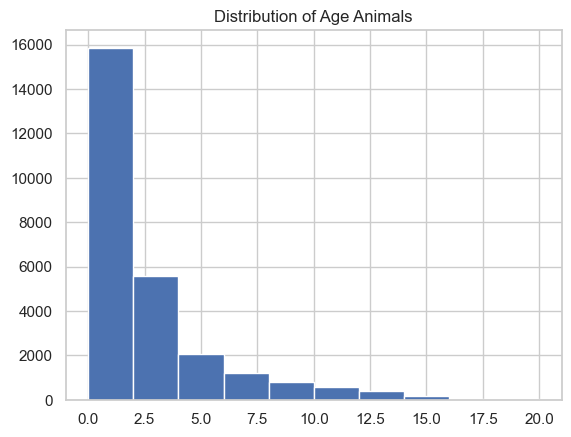

In [213]:
# Histogram Age
plt.hist(shelter_data['AgeInYears'])
plt.title('Distribution of Age Animals')
#plt.xlabel();

Boxplot of Age / Outcome Type

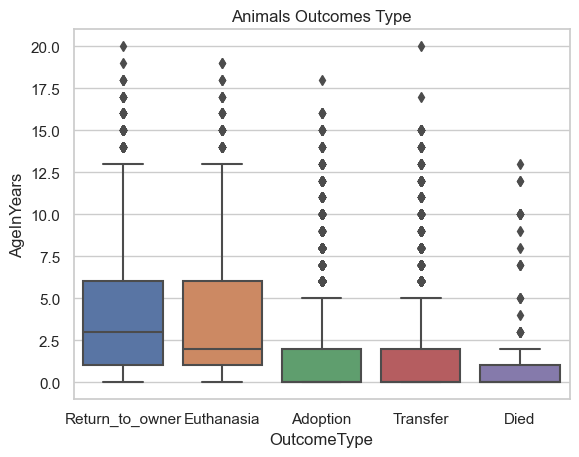

In [215]:
sns.set(style='whitegrid')
ax1 = sns.boxplot(x="OutcomeType",
                y="AgeInYears",
                data=shelter_data).set(title='Animals Outcomes Type')

plt.show()

 
4. basic visualizations 
5. change the age column to continuous age 





. X features don't include name, animal id, subtype
. map 1-5 onto the y variable (label)




**MODELING**

Baseline Accuracy

In [45]:
shelter_data['OutcomeType'].value_counts(normalize = True)

Adoption           0.403167
Transfer           0.352140
Return_to_owner    0.179177
Euthanasia         0.058141
Died               0.007375
Name: OutcomeType, dtype: float64

Our baseline accuracy, if we predicted the outcome "Adoption" every time, would be 40%

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X_dummies, y, random_state = 42, stratify = y)

In [47]:
X_train.shape, X_val.shape

((20033, 25), (6678, 25))

Logistic Regression

In [49]:
from sklearn.linear_model import LogisticRegression

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)
# Instantiate the model
logreg = LogisticRegression(solver = 'newton-cg')

# Fit the model
logreg.fit(X_train, y_train)

print(f'Training Acc: {logreg.score(X_train_sc, y_train)}')
print(f'Validation Acc: {logreg.score(X_val_sc, y_val)}')

Training Acc: 0.5382119502820346
Testing Acc: 0.52785265049416


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [102]:
logreg.coef_

array([[-1.95315242e-01,  9.64590387e-02,  3.41936659e-02,
        -2.18505287e-01, -4.27748412e-01,  2.79580213e+00,
         2.97827607e+00, -2.31546722e+00, -1.09312055e-01,
        -2.05542488e-02, -8.41325400e-02,  5.77483146e-02,
         6.80511124e-01,  5.03164213e-01, -9.24122645e-02,
        -2.45564489e-01, -2.45814605e-01, -2.78383047e-02,
        -1.21539574e-01,  1.97654648e-01,  2.15795565e-01,
         6.99749981e-02, -2.14956923e-01, -2.00818838e-01,
        -2.14347646e-02],
       [-6.67412736e-02,  8.75508286e-02,  8.86222109e-02,
        -3.83401714e-01, -2.28575671e-01, -9.12701227e-01,
        -9.02167882e-01,  8.82699169e-01,  6.80109997e-02,
         8.53306200e-02,  1.80761688e-01,  1.48190353e-01,
        -1.33782694e-01, -1.42277167e-01, -3.82960297e-02,
        -2.25778061e-02,  2.35136250e-01,  1.59392561e-01,
        -5.39042053e-03, -1.42671155e-01,  2.78914366e-02,
         1.76632118e-01,  5.60870385e-02,  5.26152585e-02,
         6.10515193e-02],
    

In [50]:
# Create dictionary of hyperparameters.
parameters = {
            'penalty':['l1','l2'], 
            'C':[0.001,0.01,0.1,1,10,100,1000]
              }

grid_search = GridSearchCV(estimator = logreg,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)

grid_search.fit(X_train, y_train)  
print("Best Parameters", grid_search.best_params_)
print("Score Train",grid_search.score(X_train,y_train))
print("Score Val",grid_search.score(X_val,y_val))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
Valu

Best Parameters {'C': 10, 'penalty': 'l2'}
Score Train 0.6314081765087606
Score Val 0.6259359089547769


In [217]:
grid_search.estimator.coef_

array([[-1.95315242e-01,  9.64590387e-02,  3.41936659e-02,
        -2.18505287e-01, -4.27748412e-01,  2.79580213e+00,
         2.97827607e+00, -2.31546722e+00, -1.09312055e-01,
        -2.05542488e-02, -8.41325400e-02,  5.77483146e-02,
         6.80511124e-01,  5.03164213e-01, -9.24122645e-02,
        -2.45564489e-01, -2.45814605e-01, -2.78383047e-02,
        -1.21539574e-01,  1.97654648e-01,  2.15795565e-01,
         6.99749981e-02, -2.14956923e-01, -2.00818838e-01,
        -2.14347646e-02],
       [-6.67412736e-02,  8.75508286e-02,  8.86222109e-02,
        -3.83401714e-01, -2.28575671e-01, -9.12701227e-01,
        -9.02167882e-01,  8.82699169e-01,  6.80109997e-02,
         8.53306200e-02,  1.80761688e-01,  1.48190353e-01,
        -1.33782694e-01, -1.42277167e-01, -3.82960297e-02,
        -2.25778061e-02,  2.35136250e-01,  1.59392561e-01,
        -5.39042053e-03, -1.42671155e-01,  2.78914366e-02,
         1.76632118e-01,  5.60870385e-02,  5.26152585e-02,
         6.10515193e-02],
    

In [158]:
df_coef = pd.DataFrame(grid_search.estimator.coef_[0], X_train.columns)

In [159]:
df_coef.sort_values(by=0, ascending=False)

,0
SexuponOutcome_Spayed Female,2.978276
SexuponOutcome_Neutered Male,2.795802
DayofWeek_5,0.680511
DayofWeek_6,0.503164
Month_8,0.215796
Month_7,0.197655
Pedigree,0.096459
Month_9,0.069975
DayofWeek_4,0.057748
Solid_Color,0.034194


In [160]:
df_coef['Features'] = df_coef.index

In [161]:
df_coef.columns

Index([0, 'Features'], dtype='object')

#### Interpretation of coefficients


**Interpretation**: For the outcome as Adopted, the fact of being Spayed female contribute 2.9 times for dogs relative to cats. 

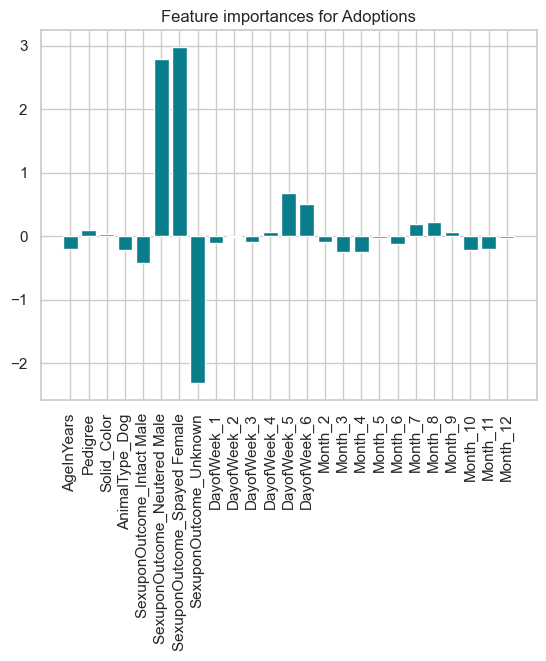

In [168]:
plt.bar(x=df_coef['Features'], height=df_coef[0], color='#087E8B')
plt.title('Feature importances for Adoptions', size=12) #for adption
plt.xticks(rotation='vertical')
plt.show()

KNN

In [51]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_params = {
    'ss__with_mean': [True, False],
    'ss__with_std': [True, False],
    'knn__p': [1, 2],
    'knn__weights': ['uniform', 'distance'],
    'knn__n_neighbors': [3, 5, 7, 10]
}

pipe_gs = GridSearchCV(pipe,pipe_params, cv=5,verbose=0)

pipe_gs.fit(X_train, y_train)
print(pipe_gs.best_params_)
pipe_gs.score(X_train, y_train), pipe_gs.score(X_val, y_val)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

{'knn__n_neighbors': 10, 'knn__p': 1, 'knn__weights': 'uniform', 'ss__with_mean': True, 'ss__with_std': False}


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

(0.6716917086806768, 0.608565438754118)

RFF

In [57]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100)
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 2, 3, 5, 7],
}

gs_rf = GridSearchCV(rf, param_grid=rf_params, cv = 5)

gs_rf.fit(X_train, y_train)
print(gs_rf.best_params_)
gs_rf.score(X_train, y_train),gs_rf.score(X_val, y_val)

{'max_depth': 7, 'n_estimators': 100}


(0.6359506813757301, 0.6211440551063192)